In [29]:
import math
import matplotlib.pyplot as plt
import time

# orbital parameters
a = 149.6e9 # semi-major axis (m)
e = 0.0167 # eccentricity

# current time
t = time.time()

# mean anomaly
M = 2 * math.pi * (t / (365.25 * 24 * 3600))

# eccentric anomaly
E = math.acos((e + math.cos(M)) / (1 + e * math.cos(M)))

# true anomaly
v = 2 * math.atan(math.sqrt((1 + e) / (1 - e)) * math.tan(E / 2))

# position in orbit
x = a * (math.cos(v) - e)
y = a * math.sqrt(1 - e**2) * math.sin(v)

# plot
plt.plot(x, y, 'ro')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

<IPython.core.display.Javascript object>

In [1]:
import numpy as np
from scipy import constants
from time import sleep, time
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_i(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def get_time_str(curr_time):
    if curr_time > constants.year:
        time_str = f"T: {round(curr_time / constants.year, 3)} years"
    elif curr_time > constants.week:
        time_str = f"T: {round(curr_time / constants.week, 3)} weeks"
    elif curr_time > constants.day:
        time_str = f"T: {round(curr_time / constants.day, 3)} days"
    elif curr_time > constants.hour:
        time_str = f"T: {round(curr_time / constants.hour, 3)} hours"
    elif curr_time > constants.minute:
        time_str = f"T: {round(curr_time / constants.minute, 3)} minutes"
    else:
        time_str = f"T: {round(curr_time, 3)} seconds"
    return time_str


def get_v_str(v):
    if abs(v) > 1000:
        v_str = f"{round(v / 1000, 2)} km/s"
    else:
        v_str = f"{round(v, 2)} m/s"
    return v_str

def gravitational_force(m1, m2, r):
    return constants.gravitational_constant * m1 * m2 / r**2

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

class AstronomicalObject:
    def __init__(self, name, mass, position, velocity=np.array([0., 0.]), radius=None, colour='b', colour2='black'):
        self.name = name
        self.mass = mass
        self.position = position  # a position matrix
        self.velocity = velocity  # a velocity vector
        self.radius = radius
        self.colour = colour
        self.colour2 = colour2
    
    def __str__(self):
        return f'Name: {self.name}\nMass: {self.mass}kg\nPosition: {self.position}m\nVelocity: <{self.velocity[0]} {self.velocity[1]}>m/s\nRadius: {self.radius/1000}km'

    def step(self, dt, acceleration=np.array([0.0, 0.0]), accel_disp = True):
        # Update position
        self.position = self.position + self.velocity * dt
        # apply displacement due to acceleration
        if accel_disp:
            self.position +=  0.5 * acceleration * dt**2
        # Update velocity
        self.velocity = self.velocity + acceleration * dt
        return self.position, self.velocity
        
    def movement_str(self):
        return f'Position: {self.position}m  Velocity: <{self.velocity[0]} {self.velocity[1]}>m/s'
    
    def __hash__(self):
        return hash(self.name)

    def clone(self):
        # shallow copies, will need to change if we ever store objects in the position or velocity
        return AstronomicalObject(self.name, self.mass, np.copy(self.position), np.copy(self.velocity), self.radius, self.colour, self.colour2)
    
    def create_variant(self, **kwargs):
        new_obj = self.clone()
        new_obj.set_properties(**kwargs)
        new_obj.velocity = new_obj.velocity.copy()
        new_obj.position = new_obj.position.copy()
        return new_obj

    def set_properties(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


class SimulationSystem:
    def __init__(self):
        self.astro_objects = []
        self.time = 0
        
    
    def add_object(self, astronomical_object: AstronomicalObject):
        self.astro_objects.append(astronomical_object)
    
    
    def step(self, dt):
        # TODO: @JonathanEnslin, this method is extreeeeemely inneficient, 1. change to not do duplicate calcs, 2. use vectorisation
        # step all objects
        self.time += dt
        if len(self.astro_objects) == 0:
            return
        # Start with 0 resulting force on all objects
        resultant_forces = [np.zeros(self.astro_objects[0].position.shape, dtype=np.float64) for _ in range(len(self.astro_objects))]
        for astro_i, astro_obj in enumerate(self.astro_objects):
            for other_astro_i, other_astro_obj in enumerate(self.astro_objects[astro_i:], astro_i):
                if astro_i == other_astro_i:
                    # Force should be zero
                    resultant_forces[astro_i] += np.zeros(other_astro_obj.position.shape)
                    continue
                # Calculate displacement matrix
                displacement_matrix = other_astro_obj.position - astro_obj.position
                # Calculate euclidean distance between two
                distance = np.linalg.norm(displacement_matrix)
                # print("Distance: ", distance)
                # Calcultate the component ratios
                component_ratios = displacement_matrix / distance
                # Calculate gravitational pull between the two
                Fg = gravitational_force(astro_obj.mass, other_astro_obj.mass, distance)
                # Get force components for astro_obj
                Fg_on_astro_obj = Fg * component_ratios
                # Add resultant forces
                resultant_forces[astro_i] += Fg_on_astro_obj
                resultant_forces[other_astro_i] -= Fg_on_astro_obj
            
        # Apply steps
        for astro_obj, resultant_force in zip(self.astro_objects, resultant_forces):
            # print("Resultant Force on:", astro_obj.name, resultant_force)
            # print("Acceleration on:   ", astro_obj.name, resultant_force / astro_obj.mass)

            astro_obj.step(dt, resultant_force / astro_obj.mass)
        
        
    def simulate(self, dt, num_steps, dimensions=2, track=True, print_progress = False):
        # TODO: @JonathanEnslin, use dicts instead and map using object name, additionally, look at include time steps
        # Initialise position and velocity tracking arrays
        positions = {astro_obj: [astro_obj.position] for astro_obj in self.astro_objects}
        velocities = {astro_obj: [astro_obj.velocity] for astro_obj in self.astro_objects}
        # ======== Print progress code ========
        curr_time, prev_time = time(), time()
        total_elapsed_time_between_prints = 1 # init to 1 to avoid zero division
        num_prints = 0
        print_period = 100 # Just a random number
        # =====================================
        time_steps = [self.time]
        for i in range(num_steps):
            if print_progress and i % print_period == 0:
                num_prints += 1
                curr_time = time()
                time_elapsed_between_prints = curr_time - prev_time
                total_elapsed_time_between_prints += time_elapsed_between_prints
                average_elapsed_time_betwen_prints = total_elapsed_time_between_prints / num_prints
                periods_left = (num_steps - i) / print_period
                estimated_time_left = periods_left * average_elapsed_time_betwen_prints
                prev_time = curr_time
                print(f"Progress: {round(i / num_steps * 100, 2)}%  -  ETA: {get_time_str(estimated_time_left)}        ", end='\r')
            self.step(dt)
            # Add updated positions and velocities
            if track:
                for astro_obj in self.astro_objects:
                    positions[astro_obj].append(astro_obj.position)
                    velocities[astro_obj].append(astro_obj.velocity)
                time_steps.append(self.time)
            
        # limit the velocity and position to dimensions dimensions
        for astro_obj in self.astro_objects:
            positions[astro_obj] = [pos[:dimensions] for pos in positions[astro_obj]]
            velocities[astro_obj] = [vel[:dimensions] for vel in velocities[astro_obj]]

        if print_progress:
            print(' '*50, "\rProgress: 100%")
            print("Complete.")
        return positions, velocities, time_steps
                    
                
# Axes to plot should be a list of lists of length 2, where each list contains the axes to plot, e.g. [['x', 'y'], ['x', 'z']]
def plot_sim_positions(positions, fig=None, ax=None, xlim=None, ylim=None, **kwargs):
    fig_or_ax_None = fig is None or ax is None
    ignore_radius = kwargs.get("ignore_radius", False)
    plt.rcParams['figure.figsize'] = [8, 8]


    # ================== plotting ==================
    if fig is None or ax is None:
        fig, (ax) = plt.subplots()

    ax.set_title(f"Solar System")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    data_len = len(positions[list(positions.keys())[0]])
    skip_size = max(int(data_len / 262801), 1)

    for astro, positions in positions.items():
        movement = list(zip(*positions))
        x_mov = movement[0][::skip_size]
        y_mov = movement[1][::skip_size]

            
        radius = astro.radius/1e5 if astro.radius is not None else None
        
        ax.plot(x_mov, y_mov, color=astro.colour, linewidth=0.4, alpha=1)
        ax.scatter(*positions[0], c=astro.colour, s=radius if not ignore_radius else None, alpha=0.6)
        ax.scatter(*positions[-1], c=astro.colour2, s=radius if not ignore_radius else None, alpha=0.4)
        ax.annotate(f"{astro.name} initial", positions[0], xytext=(10, 0), textcoords="offset pixels")
        ax.annotate(f"{astro.name} final", positions[-1], xytext=(10, -10), textcoords="offset pixels")

    if fig_or_ax_None:
        ax.set(aspect='equal')
        # ax = plt.gca()
        # ax.set_aspect('equal', adjustable='box')

    plt.show()

# if named par size_scaling is set to auto, it will scale automatically, withing the potential upper and lower bounds passed in in upper_plotbounds -> ((x_min, x_max), (y_min, y_max)) and lower_plotbounds -> ((x_min, x_max), (y_min, y_max))
# if named par size_scaling is set to fixed, it will remain to the fixed size in plotbounds -> ((x_min, x_max), (y_min, y_max))
def plot_animated_2D(positions, velocities, time_steps, time_window=None, frames=500, interval=40, **kwargs):
    
    velocities = velocities or {}
    blit =  kwargs['blit'] if 'blit' in kwargs else True
    time_anno_fontsize = kwargs['time_anno_fontsize'] if 'time_anno_fontsize' in kwargs else 8
    name_anno_fontsize = kwargs['name_anno_fontsize'] if 'name_anno_fontsize' in kwargs else 8
    size_scaling = kwargs['size_scaling'] if 'size_scaling' in kwargs else 'auto' # Default is 'auto', can be either 'auto' or 'fixed'
    # plotbounds = kwargs['plotbounds'] if 'plotbounds' in kwargs else (None, None) # Default is None, can be either None or ((x_min, x_max), (y_min, y_max)), any value can be None in the list/tuple
    plotbounds = kwargs['plotbounds'] if 'plotbounds' in kwargs else ((None, None), (None, None)) # Default is None, can be either None or ((x_min, x_max), (y_min, y_max)), any value can be None in the list/tuple
    upper_plotbounds = kwargs['upper_plotbounds'] if 'upper_plotbounds' in kwargs else ((None, None), (None, None))
    # upper_plotbounds = kwargs['upper_plotbounds'] if 'upper_plotbounds' in kwargs else (None, None)
    lower_plotbounds = kwargs['lower_plotbounds'] if 'lower_plotbounds' in kwargs else ((None, None), (None, None))
    # lower_plotbounds = kwargs['lower_plotbounds'] if 'lower_plotbounds' in kwargs else (None, None)
    margin_size = kwargs['margin_size'] if 'margin_size' in kwargs else 0.1
    ignore_radius = kwargs.get("ignore_radius", False)
    # Check if the size scaling is valid
    if size_scaling not in ['auto', 'fixed']:
        raise ValueError(f"size_scaling must be either 'auto' or 'fixed', not {size_scaling}")

    for bound, name in zip([plotbounds, upper_plotbounds, lower_plotbounds], ['plotbounds', 'upper_plotbounds', 'lower_plotbounds']):
        if not isinstance(bound, tuple) or len(bound) != 2:
            raise ValueError(f"{name} must be a tuple of length 2, not {bound}")
        for bound_i, bound in enumerate(bound):
            if not isinstance(bound, tuple) and bound is not None:
                raise ValueError(f"{name}[{bound_i}] must be a tuple of length 2, or None, not {bound}")
            if bound is None:
                continue
            for val in bound:
                if not isinstance(val, (int, float)) and val is not None:
                    raise ValueError(f"Bound values in {name} must be ints or floats, not {val} of type {type(val)}")

    # convert plotbounds to list, and inner to tuples to lists as well
    plotbounds = list(plotbounds)
    for i, bound in enumerate(plotbounds):
        if bound is not None:
            plotbounds[i] = list(bound)

    # convert upper_plotbounds to list, and inner to tuples to lists as well
    upper_plotbounds = list(upper_plotbounds)
    for i, bound in enumerate(upper_plotbounds):
        if bound is not None:
            upper_plotbounds[i] = list(bound)

    # convert lower_plotbounds to list, and inner to tuples to lists as well
    lower_plotbounds = list(lower_plotbounds)
    for i, bound in enumerate(lower_plotbounds):
        if bound is not None:
            lower_plotbounds[i] = list(bound)


    velocities_seperated = {astro: list(zip(*velocities[astro])) for astro in velocities}

    # Set flag for autoscaling
    autoscaling = size_scaling == 'auto'

    # Set the plot bounds default values to the max and x and y and min x and y values out of all the lists/arrays in the positions dict
    overall_min_y = min([min([pos[1] for pos in pos_list]) for pos_list in positions.values()])
    overall_max_y = max([max([pos[1] for pos in pos_list]) for pos_list in positions.values()])
    overall_min_x = min([min([pos[0] for pos in pos_list]) for pos_list in positions.values()])
    overall_max_x = max([max([pos[0] for pos in pos_list]) for pos_list in positions.values()])
    
    if not autoscaling:
        # If the plotbounds are not set, set them to the overall min and max values
        if plotbounds[0] is None:
            plotbounds = [[overall_min_x - margin_size * np.abs(overall_min_x), overall_max_x + margin_size * np.abs(overall_max_x)], plotbounds[1]]
        if plotbounds[1] is None:
            plotbounds = [plotbounds[0], [overall_min_y - margin_size * np.abs(overall_min_y), overall_max_y + margin_size * np.abs(overall_max_y)]]
        if plotbounds[0][0] is None:
            plotbounds[0][0] = overall_min_x - margin_size * np.abs(overall_min_x)
        if plotbounds[0][1] is None:
            plotbounds[0][1] = overall_max_x + margin_size * np.abs(overall_max_x)
        if plotbounds[1][0] is None:
            plotbounds[1][0] = overall_min_y - margin_size * np.abs(overall_min_y)
        if plotbounds[1][1] is None:
            plotbounds[1][1] = overall_max_y + margin_size * np.abs(overall_max_y)
    else:
        # If the plotbounds are not set, set them to the overall min and max values
        # Margins are added if the plotbounds are not explicitly set
        for i, bound in enumerate(upper_plotbounds):
            if bound is None:
                upper_plotbounds[i] = [float('-inf'), float('inf')]
        
        for i, bound in enumerate(lower_plotbounds):
            if bound is None:
                lower_plotbounds[i] = [-0., -0.]
        
        for bound in upper_plotbounds:
            if bound[0] is None:
                bound[0] = float('-inf')
            if bound[1] is None:
                bound[1] = float('inf')

        for i in range(len(lower_plotbounds)):
            for j in range(len(lower_plotbounds[i])):
                if lower_plotbounds[i][j] is None:
                    lower_plotbounds[i][j] = -0.
            
    # Create figure
    fig = plt.figure()
    # axis = plt.axes()
    # axis.set_aspect('equal', 'box')
    axis = plt.axes(xlim=plotbounds[0], ylim=plotbounds[1], aspect='equal')

    # Extract the astronomical objects
    astros = list(positions.keys())
    # Create a line for each astro
    lines = [axis.plot([], [], lw = 1, alpha=0.5, c=astro.colour)[0] for astro in astros]
    # Create a scatter plot for each astro
    scatters = [axis.scatter([], [], c=astro.colour, s=None if (astro.radius is None or ignore_radius) else 2*astro.radius/2e6) for astro in astros]
    
    # Create the annotations
    annotations = [axis.annotate(f"{astro.name}", (0, 0), alpha=0.7, xytext=(np.random.randint(-10, 10), np.random.randint(-10, 10)), textcoords="offset pixels", fontsize=name_anno_fontsize) for astro in astros]

    # Add speed to the annotations where astro is in seperated_velocities
    for i, astro in enumerate(astros):
        if astro in velocities_seperated:
            annotations[i].set_text(f"{astro.name}\nx_v: {get_v_str(velocities_seperated[astro][0][0])}\ny_v: {get_v_str(velocities_seperated[astro][1][0])}")

    # Create the annotation for time
    anno_time = axis.annotate(f"Time: {time_steps[0]}", xy=(0,0), xycoords='axes fraction', fontsize=time_anno_fontsize, 
            xytext=(0,0), textcoords='offset points',
            bbox=dict(boxstyle="square", fc="w"),
            arrowprops=dict(arrowstyle="->"))

    # Extract the x and y positions for all astros
    x_positions = []
    y_positions = []
    for astro in astros:
        x_pos, y_pos = zip(*positions[astro])
        x_positions.append(x_pos)
        y_positions.append(y_pos)
    
    # get the number of data points
    data_len = len(positions[astros[0]])
#     print(data_len)
    def init():
        return *lines, *scatters
    
    skip_size = max(int(data_len / 262801), 1)
    # print(skip_size)
    def animate(i):
        xi, yi = int(i*data_len/frames), int(i*data_len/frames)
        if time_window is not None:
            # Only display within time window
            curr_time = time_steps[yi]  # The time step of the current frame
            # Find what time step should be searched for
            search_time = curr_time - time_window
            # Find the index of the time step
            time_i = np.searchsorted(time_steps, search_time, side='right')
        else:
            time_i = 0
        
        #  set x/y_min and x/y_max to negative and positive infinity
        y_min, y_max = float('inf'), float('-inf')
        x_min, x_max = float('inf'), float('-inf')

        for astro_index in range(len(astros)):
            x_data = x_positions[astro_index][time_i:xi:skip_size]
            y_data = y_positions[astro_index][time_i:yi:skip_size]
            lines[astro_index].set_data(x_data, y_data)
            # scale the plot
            if len(x_data) != 0 and autoscaling:
                temp_y_min = min(y_data)
                temp_y_max = max(y_data)
                temp_x_min = min(x_data)
                temp_x_max = max(x_data)
                # update the min and max
                y_min = min(y_min, temp_y_min)
                y_max = max(y_max, temp_y_max)
                x_min = min(x_min, temp_x_min)
                x_max = max(x_max, temp_x_max)

                # take the upper and lower bounds of the plot into consideration
                if upper_plotbounds is not None: # If statement is not necessary, but is there for clarity/just incase
                    # Not allowed to go bigger than the upper bounds
                    y_max = min(y_max, upper_plotbounds[1][1])
                    x_max = min(x_max, upper_plotbounds[0][1])
                    # Not allowed to go smaller than upper bounds lower limit
                    y_min = max(y_min, upper_plotbounds[1][0])
                    x_min = max(x_min, upper_plotbounds[0][0])
                if lower_plotbounds is not None:
                    # Not allowed to go larger than lower bounds lower limit
                    y_min = min(y_min, lower_plotbounds[1][0])
                    x_min = min(x_min, lower_plotbounds[0][0])
                    # Not allowed to go smaller than lower bounds upper limit
                    y_max = max(y_max, lower_plotbounds[1][1])
                    x_max = max(x_max, lower_plotbounds[0][1])

                # set the figure limits to be equal to the extremes
                # axis.set_ylim(bottom=minmin - 0.5 * np.abs(minmin), top=maxmax + 0.5 * np.abs(maxmax))
                # axis.set_xlim(left=minmin - 0.5 * np.abs(minmin), right=maxmax + 0.5 * np.abs(maxmax))
                axis.set_ylim(bottom=y_min - margin_size * np.abs(y_min), top=y_max + margin_size * np.abs(y_max))
                axis.set_xlim(left=x_min - margin_size * np.abs(x_min), right=x_max + margin_size * np.abs(x_max))

            scatters[astro_index].set_offsets([x_positions[astro_index][xi], y_positions[astro_index][yi]])
            annotations[astro_index].xy = (x_positions[astro_index][xi], y_positions[astro_index][yi])

        
            if astros[astro_index] in velocities_seperated:
                annotations[astro_index].set_text(f"{astros[astro_index].name}\nx_v: {get_v_str(velocities_seperated[astros[astro_index]][0][xi])}\ny_v: {get_v_str(velocities_seperated[astros[astro_index]][1][xi])}")

        # update the time text
        anno_time.set_text(get_time_str(time_steps[yi]))

        return *lines, *scatters
            
    return animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = frames,
                            interval = interval,
                            blit = blit)
    

def progress_callback_func_factory():
    start_time = time()
    def progress_callback_func(frame, total_frames):
        frame += 1
        elapsed_time = time() - start_time
        avg_time_per_frame = elapsed_time / frame
        remaining_time = avg_time_per_frame * (total_frames - frame)
        print(f"Frame {frame}/{total_frames} - {(frame/total_frames*100):.2f}% - Remaining time: {get_time_str(remaining_time)} - Elapsed time: {get_time_str(elapsed_time)}", ' '*10, end='\r')
    return progress_callback_func

In [2]:
# Default solar system objects
sun = AstronomicalObject("Sun",
                         mass=1.989e+30,
                         position=np.array([0., 0]),
                         velocity=np.array([0., 0]),
                         radius=696_340_000,
                        #  radius=None,
                         colour = 'y',
                         colour2 = 'orange'
                        )
earth = AstronomicalObject("Earth",
                           mass=5.972e+24,
                           position=np.array([constants.au, 0.]),
                           velocity=np.array([0., 107_226*constants.kmh]), 
                           radius=None,
                           colour = 'b',
                           colour2 = 'green'
                          )
moon = AstronomicalObject("Moon",
                            mass=7.34767309e+22,    
                            position=np.array([constants.au + 384_400_000, 0.]),
                            velocity=np.array([0., 107_226*constants.kmh + 3683*constants.kmh]),
                            radius=None,
                            colour = 'grey',
                            colour2 = 'grey'
                            )

Step size: T: 6.0 minutes
Progress: 100%                                     
Complete.
Time elapsed:  3.0749993324279785 seconds
Frame 720/720 - 100.00% - Remaining time: T: 0.0 seconds - Elapsed time: T: 23.725 seconds                        


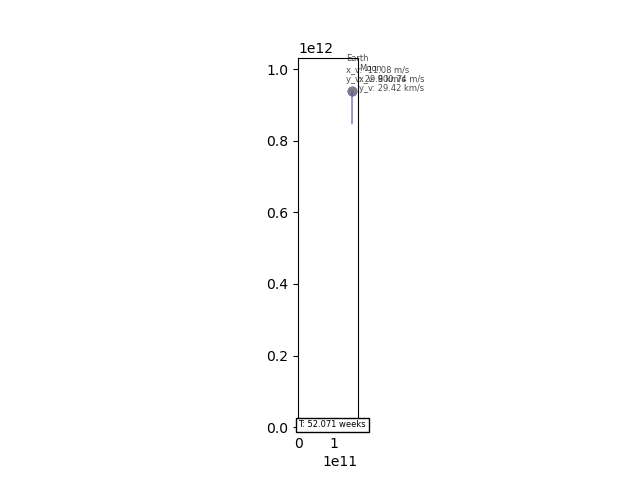

In [6]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.animation as animation

m1 = 0.25*2e30
m2 = 2e30

R = 1e11
centre_of_mass = (m1 * 0 + m2 * R) / (m1 + m2)
r1 = centre_of_mass
r2 = R - centre_of_mass

Fg = (constants.gravitational_constant * m1 * m2) / R**2

v1 = np.sqrt(Fg * r1 / m1) 
v2 = np.sqrt(Fg * r2 / m2)

star1 = AstronomicalObject("Star 1",
                            mass=m1,
                            position=np.array([0., r1]),
                            velocity=np.array([-v1, 0.]),
                            radius=sun.radius/2,
                            colour = 'y',
)

star2 = AstronomicalObject("Star 2",
                            mass=m2,
                            position=np.array([0., -r2]),
                            velocity=np.array([v2, 0.]),
                            radius=sun.radius,
                            colour = 'y',
)


# Setup of simulation
sim = SimulationSystem()
sun_clone = sun.clone()
earth_clone = earth.clone()
moon_clone = moon.clone()

# sim.add_object(sun_clone)
sim.add_object(earth_clone)
sim.add_object(moon_clone)

# sim.add_object(star1.clone())
# sim.add_object(star2.clone())

start_time = time()

# Run simulation
# positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=2, print_progress=True, track=False)

timespan = 1*constants.year
step_size = 360
print("Step size:", get_time_str(step_size))
positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=2, print_progress=True)
sim.step(step_size)

end_time = time()
print("Time elapsed: ", end_time - start_time, "seconds")

# del velocities[sun_clone]
# del positions[sun_clone]

# if input("Would you like the plot to be animated? (y/n) ") == 'y':
if True:
    
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 60 * constants.day, frames = 400, interval=15, size_scaling='fixed', plotbounds=((-0.2*constants.au, 1.2*constants.au), (-0.01e12, 1.1e12)), blit=True, name_anno_fontsize=6)
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 1*constants.year, frames = 800, interval=15, size_scaling='fixed', blit=True, name_anno_fontsize=6)
    ani = plot_animated_2D(positions, velocities, time_steps, time_window=5*constants.week, frames = 720, interval=15, size_scaling='auto', blit=True, margin_size=0.1, time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=False)
    ani.save('moon-earth-no-sun.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    print()
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window=5*constants.week, frames = 720, interval=15, size_scaling='auto', blit=True, margin_size=0.1, upper_plotbounds=(None, (None, 3e11)), lower_plotbounds=(None, (-0.1e11, None)), time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=False)
    # ani.save('moon-earth-no-sun.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    # print()
    # print("Saved")
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window=20*constants.week, frames = 720, interval=15, size_scaling='fixed', blit=True, margin_size=0.1, upper_plotbounds=(None, (None, 3e11)), lower_plotbounds=(None, (-0.1e11, None)), time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=False)
    # ani.save('moon-around-earth-sun-removed-fixed.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    # print()
    # print("Saved")
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window=0.5*constants.week, frames = 720, interval=15, size_scaling='auto', blit=True, margin_size=0.1, upper_plotbounds=(None, (None, 3e11)), lower_plotbounds=(None, (-0.1e11, None)), time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=False)
    # ani.save('moon-around-earth-sun-removed-half-week window.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    # print()
    # print("Saved")
    
else:
    plot_sim_positions(positions, ignore_radius=True)
    plt.show()

Step size: T: 24.0 minutes
Progress: 100%                                     
Complete.
Time elapsed:  3.698528528213501 seconds


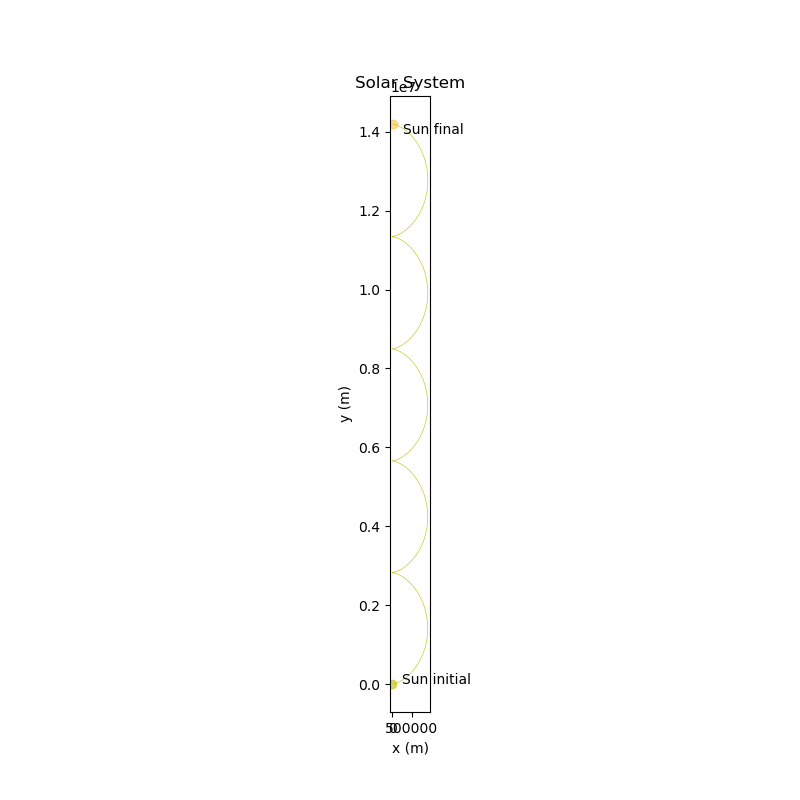

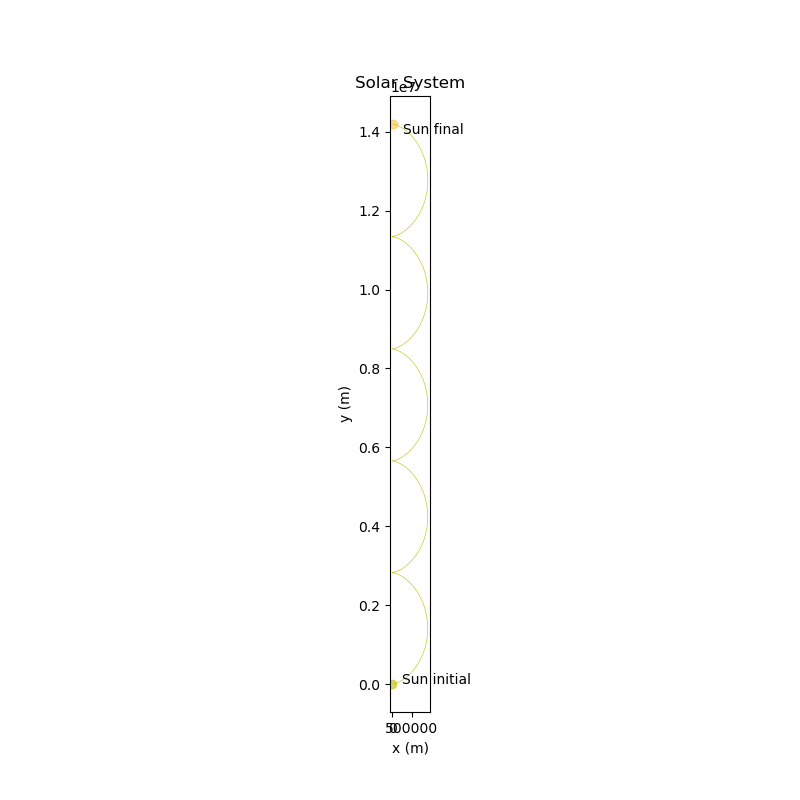

In [37]:
%matplotlib widget

import matplotlib.pyplot as plt
import matplotlib.animation as animation

# create arrays of len 2 with random values
# np.random.rand(2)

# Setup of simulation
sim = SimulationSystem()

# Add objects
sim.add_object(sun.create_variant(velocity=np.array([0., 1.4 / (5*constants.year)])))
sim.add_object(earth.create_variant())

timespan = 1 * constants.hour
step_size = 360*4
print("Step size:", get_time_str(step_size))
start_time = time()

# Run simulation
# positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=2, print_progress=True, track=False)

timespan = 5*constants.year
positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=2, print_progress=True)
sim.step(step_size)

end_time = time()
print("Time elapsed: ", end_time - start_time, "seconds")


# if input("Would you like the plot to be animated? (y/n) ") == 'y':
if False:
    
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 60 * constants.day, frames = 400, interval=15, size_scaling='fixed', plotbounds=((-0.2*constants.au, 1.2*constants.au), (-0.01e12, 1.1e12)), blit=True, name_anno_fontsize=6)
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 1*constants.year, frames = 800, interval=15, size_scaling='fixed', blit=True, name_anno_fontsize=6)
    ani = plot_animated_2D(positions, velocities, time_steps, time_window= None, frames = 360, interval=15, size_scaling='fixed', blit=True, margin_size=0.1, upper_plotbounds=(None, (None, 3e11)), lower_plotbounds=(None, (-0.1e11, None)), time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=True)
    ani.save('new-animation.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    print()
    print("Saved")
else:
    del positions[sim.astro_objects[1]]
    plot_sim_positions(positions, ignore_radius=True)
    plt.show()

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
from time import time

star_001 = AstronomicalObject("Star 001",
                                mass=1e30,
                                position=np.array([0., 0]),
                                velocity=np.array([0., 0]),
                                colour = 'orange',
                            )  

planet_001 = AstronomicalObject("Planet 001",
                                mass=1,
                                position=np.array([1e10, 0.]),
                                velocity=np.array([0., (constants.gravitational_constant*1e20)**0.5]), 
                                colour = 'pink',
                            )

planet_002 = AstronomicalObject("Planet 002",
                                mass=1,
                                position=np.array([-1e10, 0.]),
                                velocity=np.array([0., -(constants.gravitational_constant*1e20)**0.5]), 
                                colour = 'purple',
                            )

star_003 = AstronomicalObject("Star 003",
                                mass=4*star_001.mass,
                                radius=sun.radius,
                                position=np.array([1e10, 0.]),
                                velocity=np.array([0., (constants.gravitational_constant*1e20)**0.5]), 
                                colour = 'pink',
                            )

star_004 = AstronomicalObject("Star 004",
                                mass=4*star_001.mass,
                                radius=sun.radius,
                                position=np.array([-1e10, 0.]),
                                velocity=np.array([0., -(constants.gravitational_constant*1e20)**0.5]), 
                                colour = 'blue',
                            )

star_005 = AstronomicalObject("Star 005",
                                mass=4*star_001.mass,
                                radius=sun.radius,
                                position=np.array([0., 1e10]),
                                velocity=np.array([-(constants.gravitational_constant*1e20)**0.5, 0.]),
                                colour = 'red',
                            )

star_006 = AstronomicalObject("Star 006",
                                mass=4*star_001.mass,   
                                radius=sun.radius,
                                position=np.array([0., -1e10]),
                                velocity=np.array([(constants.gravitational_constant*1e20)**0.5, 0.]),
                                colour = 'green',
                            )


# Setup of simulation
sim = SimulationSystem()
# sim.add_object(star_001)
# sim.add_object(planet_001)
# sim.add_object(planet_002)
# sim.add_object(earth.clone())
# sim.add_object(star_003)
# sim.add_object(star_004)
# sim.add_object(star_005)
# sim.add_object(star_006)
sim.add_object(sun.clone())
sim.add_object(earth.create_variant(velocity=1.5*earth.velocity))

timespan = 0.5*constants.year
# orbits = 4.0
# timespan = orbits*0.02439*constants.year
# timespan = 1.5*constants.week
# step_size = 920
# step_size = 20
# step_size = timespan/100000
step_size = timespan/10000

start_time = time()

# Run simulation
positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), print_progress=True)
# sim.step(step_size)

end_time = time()
print("Time elapsed: ", end_time - start_time, "seconds")


# if input("Would you like the plot to be animated? (y/n) ") == 'y':
if True:
    
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 60 * constants.day, frames = 400, interval=15, size_scaling='fixed', plotbounds=((-0.2*constants.au, 1.2*constants.au), (-0.01e12, 1.1e12)), blit=True, name_anno_fontsize=6)
    # ani = plot_animated_2D(positions, velocities, time_steps, time_window= 1*constants.year, frames = 800, interval=15, size_scaling='fixed', blit=True, name_anno_fontsize=6)
    ani = plot_animated_2D(positions, velocities, time_steps, time_window= None, frames = 360, interval=15, size_scaling='auto', blit=True, margin_size=0.1, upper_plotbounds=(None, (None, 3e11)), lower_plotbounds=(None, (-0.1e11, None)), time_anno_fontsize=6, name_anno_fontsize=6, ignore_radius=True)
    ani.save('new-animation.mp4', writer='ffmpeg', fps=24, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())
    print()
    print("Saved")
else:
    plot_sim_positions(positions, ignore_radius=True)
    plt.show()

ZeroDivisionError: float division by zero

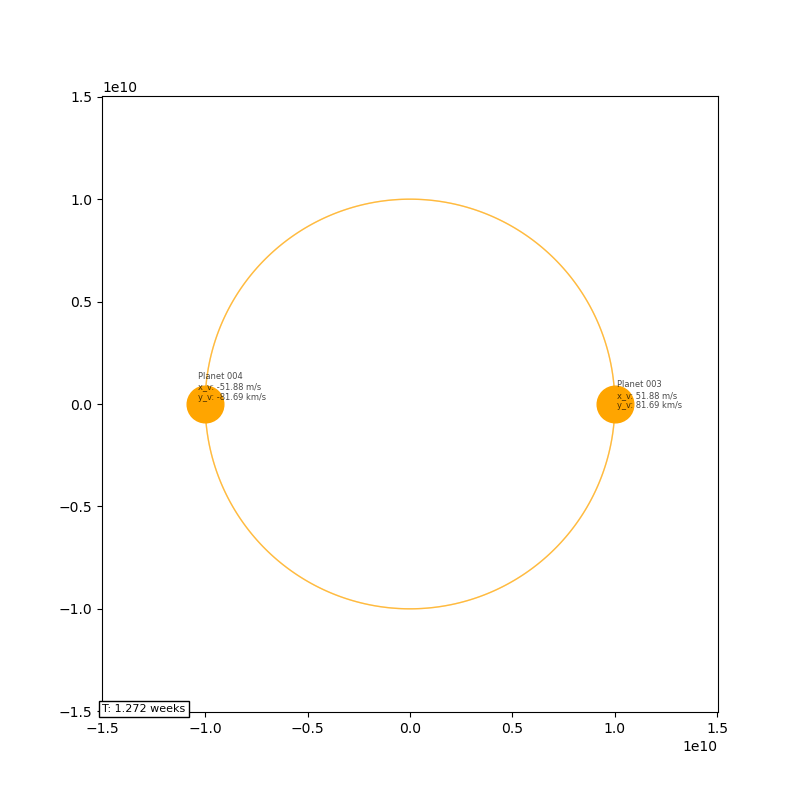

In [77]:
ani = plot_animated_2D(positions, velocities, time_steps, time_window= None, frames = 1000, interval=15, size_scaling='fixed', blit=True, margin_size=0.5, name_anno_fontsize=6)
ani.save('test.mp4', writer='ffmpeg', fps=10, dpi=250, bitrate=2500, progress_callback=progress_callback_func_factory())

In [94]:
from time import time

start = time()
# Initialize matrix
matrix = np.random.random((100,3))
n_points = matrix.shape[0]

# Initialize distance matrix with zeros
distance_matrix = np.zeros((n_points, n_points))
for thig in range(1000):

    # Calculate Euclidean distance between each pair of coordinates
    for i in range(n_points):
        for j in range(n_points):
            distance_matrix[i, j] = np.linalg.norm(matrix[i] - matrix[j])
end = time()
print(end-start)

31.853526830673218


In [104]:
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

print(matrix[:])
print("=================")
print(matrix[:, np.newaxis])
print("=================")
print(matrix[:, np.newaxis] - matrix)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[[1 2 3]]

 [[4 5 6]]

 [[7 8 9]]]
[[[ 0  0  0]
  [-3 -3 -3]
  [-6 -6 -6]]

 [[ 3  3  3]
  [ 0  0  0]
  [-3 -3 -3]]

 [[ 6  6  6]
  [ 3  3  3]
  [ 0  0  0]]]


In [105]:
# Initialize matrix
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

euclidean_distances = np.linalg.norm(matrix[:, np.newaxis] - matrix, axis=-1)
print(euclidean_distances)
print(euclidean_distances[0][2])

n_points = matrix.shape[0]

# Initialize distance matrix with zeros
distance_matrix = np.zeros((n_points, n_points))
print()
# Calculate Euclidean distance between each pair of coordinates
for i in range(n_points):
    for j in range(n_points):
        distance_matrix[i, j] = np.linalg.norm(matrix[i] - matrix[j])
print(distance_matrix)

[[ 0.          5.19615242 10.39230485]
 [ 5.19615242  0.          5.19615242]
 [10.39230485  5.19615242  0.        ]]
10.392304845413264

[[ 0.          5.19615242 10.39230485]
 [ 5.19615242  0.          5.19615242]
 [10.39230485  5.19615242  0.        ]]


Progress: 100%                                     
Complete.
Time elapsed:  1.068497657775879 seconds


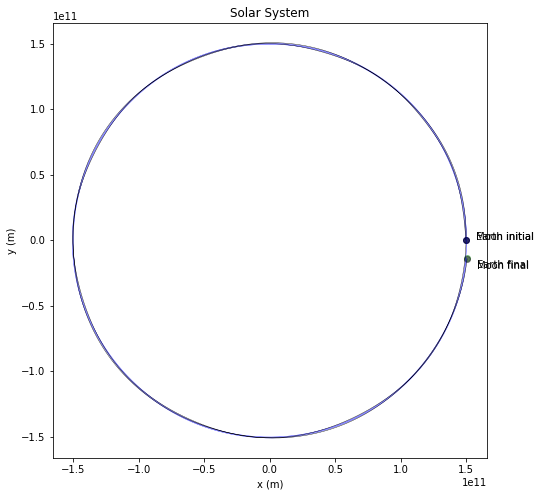

Saving frame 359 of 360
Saved


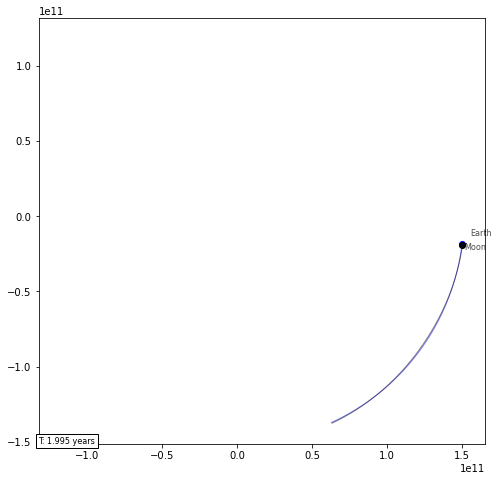

In [114]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
 
from time import time

sun = AstronomicalObject("Sun",
                         mass=1.989e+30,
                         position=np.array([0., 0]),
                         velocity=np.array([0., 0]),
                        #  radius=696_340_000,
                         radius=None,
                         colour = 'y',
                         colour2 = 'orange'
                        )
sun2 = AstronomicalObject("Sun2",
                           mass=1.989e+30,
                           position=np.array([constants.au, 0.0]),
                           velocity=np.array([0, 107_226*constants.kmh // 1.5]), 
                        #    radius=696_340_000,
                           radius=None,
                           colour = 'red',
                           colour2 = 'red'
                          )
sun3 = AstronomicalObject("Sun3",
                           mass=1.989e+30,
                           position=np.array([-constants.au, 0.0]),
                           velocity=np.array([0, -107_226*constants.kmh // 1.5]), 
                        #    radius=637_1000,
                           radius=None,
                           colour = 'y',
                           colour2 = 'y'
                          )
earth = AstronomicalObject("Earth",
                           mass=5.972e+24,
                           position=np.array([constants.au, 0.0]),
                           velocity=np.array([0, 29789.111319772674]), 
#                            velocity=np.array([0, 107_226*constants.kmh]), 
                        #    radius=637_1000,
                           radius=None,
                           colour = 'b',
                           colour2 = 'green'
                          )
earth2 = AstronomicalObject("Earth2",
                           mass=5.972e+24,
                           position=np.array([0.0, -constants.au]),
                           velocity=np.array([107_226*constants.kmh, 0.]), 
#                            radius=637_1000,
                           radius=None,
                           colour = 'purple',
                           colour2 = 'violet'
                          )
moon = AstronomicalObject("Moon",
                           mass=7.34767309e+22,
                           position=np.array(earth.position + [0., 384_399_000]),
                           velocity=np.array(earth.velocity + [-1018.290370245874, 0.]), 
                        #    radius=173_7400,
                           radius=None,
                           colour = 'black',
                           colour2 = 'black'
                          )

# Setup of simulation
sim = SimulationSystem()
sim.add_object(earth)
sim.add_object(sun)
sim.add_object(moon)
# sim.add_object(earth2)
# sim.add_object(sun2)
# sim.add_object(sun3)

timespan = 2*constants.year
step_size = 3600

start_time = time()

# Run simulation
positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), print_progress=True)

end_time = time()
print("Time elapsed: ", end_time - start_time, "seconds")

del positions[sun]
del velocities[sun]
# del positions[earth]
# del velocities[earth]
plot_sim_positions(positions)
ani = plot_animated_2D(positions, velocities, time_steps, time_window= 60 * constants.day, frames = 360, interval=15, size_scaling='auto', lower_plotbounds=((-1.2e11, 1.2e11), (-1.2e11, 1.2e11)))
def progress_callback(frame, total_frames):
    print(f"Saving frame {frame} of {total_frames}\r", end="")
ani.save('new-animation.mp4', writer='ffmpeg', fps=24, dpi=150, bitrate=1250, progress_callback=progress_callback)
print()
print("Saved")
# plt.show()

In [27]:
moon.velocity

array([ -806.34290692, 29355.25287299])

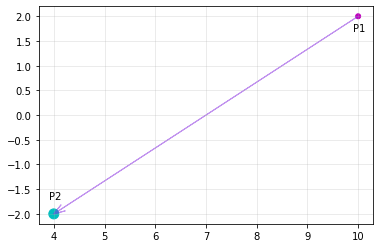

In [169]:
%matplotlib inline
particle1: AstronomicalObject = AstronomicalObject("Random Particle 1",
                         mass=1.0,
                         position=np.array([10., 2]),
                         velocity=np.array([2., -1]),
                         radius=2.5,
                         colour='m'
                        )
    
particle2: AstronomicalObject = AstronomicalObject("Random Particle 2",
                         mass=1.0,
                         position=np.array([4., -2]),
                         velocity=np.array([2., -1]),
                         radius=10,
                         colour='c'
                        )
fig, ax = plt.subplots()
ax.scatter(*zip(particle1.position, particle2.position), s = [particle1.radius*10, particle2.radius*10], c = [particle1.colour, particle2.colour])
ax.arrow(*particle1.position, *(particle2.position - particle1.position), head_width=0.15, overhang=1, edgecolor='blueviolet', alpha=0.5, length_includes_head = True)
ax.grid(alpha=0.3)
ax.annotate("P1", particle1.position, xytext=(-5, -15), textcoords="offset pixels")
ax.annotate("P2", particle2.position, xytext=(-5, 15), textcoords="offset pixels")
plt.show()

In [ ]:
from time import time

start = time()
# Initialize matrix
# matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
matrix = np.random.random((100,3))

for thing in range(1000):

# Calculate Euclidean distance between each pair of coordinates
    euclidean_distances = np.linalg.norm(matrix[:, np.newaxis] - matrix, axis=-1)
end = time()
print(end-start)

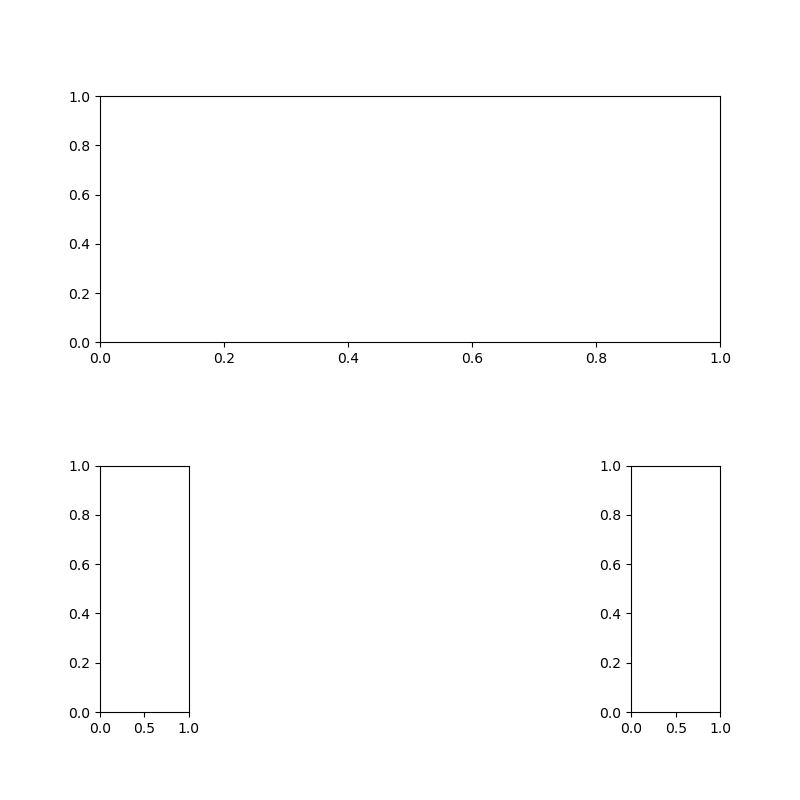

In [69]:
from matplotlib import pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

ax = plt.GridSpec(2, 2)
ax.update(wspace=5, hspace=0.5)

ax1 = plt.subplot(ax[0, :])
ax2 = plt.subplot(ax[1, 0])
ax3 = plt.subplot(ax[1, 1])

plt.show()

In [ ]:
%matplotlib widget

satellite = AstronomicalObject("Sat",
                         mass=350,
                         position=np.array([-2e6, 1e6]),
                         velocity=np.array([1000., 0]),
                         radius=None,
                         colour = 'y',
                         colour2 = 'black'
                        )

stationaryEarth = AstronomicalObject("StatEarth",
                            mass=5.972e+24,
                            position=np.array([0.0, 0.0]),
                            velocity=np.array([0, 0]),
                            radius=None,
                            colour = 'b',
                            colour2 = 'blue'
                            )

earth = AstronomicalObject("Earth",
                           mass=5.972e+24,
                           position=np.array([constants.au, 0.0]),
                           velocity=np.array([0, 29789.111319772674]), 
#                            velocity=np.array([0, 107_226*constants.kmh]), 
                        #    radius=637_1000,
                           radius=None,
                           colour = 'b',
                           colour2 = 'blue'
                          )

sun = AstronomicalObject("Sun",
                         mass=1.989e+30,
                         position=np.array([0., 0]),
                         velocity=np.array([0., 0]),
                        #  radius=696_340_000,
                         radius=None,
                         colour = 'y',
                         colour2 = 'orange'
                        )

sim = SimulationSystem()
sim.add_object(stationaryEarth)
sim.add_object(satellite)
# sim.add_object(sun)

timespan = 100
step_size = 0.01
sim.simulate(dt=step_size, num_steps = int(timespan / step_size), print_progress=True)
timespan = 3.5*constants.minute - 100
step_size = 0.001
positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), print_progress=True)
fig, (ax, ax2, ax3) = plt.subplots(3)
# plot_sim_positions(positions, fig=fig, ax=ax, ylim=[-0.2e11, 0.2e11])
plot_sim_positions(positions, fig=fig, ax=ax)
sat_vel = velocities[satellite]
x_v = list(zip(*sat_vel))[0]
print(max(x_v))
ax2.plot(time_steps, x_v)
ax2.set_title("Satellite Velocity")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Velocity (m/s)")
# add text in bottom right corner displaying max speed
ax2.text(0.95, 0.01, f"Max V: {max(abs(max(x_v)), abs(min(x_v))):.2f} m/s {(max(abs(max(x_v)), abs(min(x_v))) / constants.speed_of_light * 100):.2f}%c",
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax2.transAxes,
         color='black', fontsize=10)

# plot the y velocity on ax3
y_v = list(zip(*sat_vel))[1]
print(max(y_v))
ax3.plot(time_steps, y_v)
ax3.set_title("Satellite Velocity")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Velocity (m/s)")
# add text in bottom right corner displaying max speed
ax3.text(0.95, 0.01, f"Max V: {max(abs(max(y_v)), abs(min(y_v))):.2f} m/s {(max(abs(max(y_v)), abs(min(y_v))) / constants.speed_of_light * 100):.2f}%c",
         verticalalignment='bottom', horizontalalignment='right',
         transform=ax3.transAxes,
         color='black', fontsize=10)


del velocities[stationaryEarth]

ani = plot_animated_2D(positions, velocities, time_steps, fig=fig, ax=ax, frames=400, interval=25, blit=False, size_scaling='fixed', margin_size=0.2, plotbounds=((-1.1e7, 0.1e7), None))
def progress_callback(frame, total_frames):
    print(f"Saving frame {frame} of {total_frames}\r", end="")
ani.save('new-animation.mp4', writer='ffmpeg', fps=30, dpi=200, bitrate=300, progress_callback=progress_callback)
print()
print("Saved")
# plt.show()
      
# plt.plot(time_steps, x_v)
# plt.show()

In [33]:
fun = f1()

In [34]:
fun()
fun()
fun()

UnboundLocalError: local variable 'a' referenced before assignment

In [102]:
'A'.lower()
type('A')

str

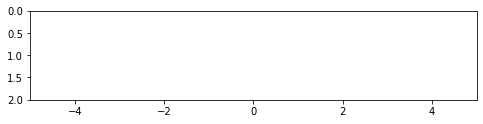

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.set_xlim(-5, 5)
ax.set_ylim(2, 0)
ax.set_aspect("equal")
plt.show()


In [ ]:
import numpy as np
from scipy import constants
from time import sleep, time
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def circular_orbital_velocity(mass, orbital_radius):
    return np.sqrt(constants.gravitational_constant * mass / orbital_radius)

def orbital_radius(mass, velocity):
    return constants.gravitational_constant * mass / velocity**2

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_i(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def get_time_str(curr_time):
    if curr_time > constants.year:
        time_str = f"T: {round(curr_time / constants.year, 3)} years"
    elif curr_time > constants.week:
        time_str = f"T: {round(curr_time / constants.week, 3)} weeks"
    elif curr_time > constants.day:
        time_str = f"T: {round(curr_time / constants.day, 3)} days"
    elif curr_time > constants.hour:
        time_str = f"T: {round(curr_time / constants.hour, 3)} hours"
    elif curr_time > constants.minute:
        time_str = f"T: {round(curr_time / constants.minute, 3)} minutes"
    else:
        time_str = f"T: {round(curr_time, 3)} seconds"
    return time_str


def get_v_str(v):
    if abs(v) > 1000:
        v_str = f"{round(v / 1000, 2)} km/s"
    else:
        v_str = f"{round(v, 2)} m/s"
    return v_str

def gravitational_force(m1, m2, r):
    return constants.gravitational_constant * m1 * m2 / r**2

def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

class AstronomicalObject:
    def __init__(self, name, mass, position, velocity=np.array([0., 0.]), radius=None, colour='b', colour2='black'):
        self.name = name
        self.mass = mass
        self.position = position  # a position matrix
        self.velocity = velocity  # a velocity vector
        self.radius = radius
        self.colour = colour
        self.colour2 = colour2
    
    def __str__(self):
        return f'Name: {self.name}\nMass: {self.mass}kg\nPosition: {self.position}m\nVelocity: <{self.velocity[0]} {self.velocity[1]}>m/s\nRadius: {self.radius/1000}km'

    def step(self, dt, acceleration=np.array([0.0, 0.0]), accel_disp = True):
        # Update position
        self.position = self.position + self.velocity * dt
        # apply displacement due to acceleration
        if accel_disp:
            self.position +=  0.5 * acceleration * dt**2
        # Update velocity
        self.velocity = self.velocity + acceleration * dt
        return self.position, self.velocity
        
    def movement_str(self):
        return f'Position: {self.position}m  Velocity: <{self.velocity[0]} {self.velocity[1]}>m/s'
    
    def __hash__(self):
        return hash(self.name)

    def clone(self):
        # shallow copies, will need to change if we ever store objects in the position or velocity
        return AstronomicalObject(self.name, self.mass, np.copy(self.position), np.copy(self.velocity), self.radius, self.colour, self.colour2)
    
    def create_variant(self, **kwargs):
        new_obj = self.clone()
        new_obj.set_properties(**kwargs)
        new_obj.velocity = new_obj.velocity.copy()
        new_obj.position = new_obj.position.copy()
        return new_obj

    def set_properties(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)


class SimulationSystem:
    def __init__(self):
        self.astro_objects = []
        self.time = 0
        
    
    def add_object(self, astronomical_object: AstronomicalObject):
        self.astro_objects.append(astronomical_object)
    
    
    def step(self, dt):
        # TODO: @JonathanEnslin, this method is extreeeeemely inneficient, 1. change to not do duplicate calcs, 2. use vectorisation
        # step all objects
        self.time += dt
        if len(self.astro_objects) == 0:
            return
        # Start with 0 resulting force on all objects
        resultant_forces = [np.zeros(self.astro_objects[0].position.shape, dtype=np.float64) for _ in range(len(self.astro_objects))]
        for astro_i, astro_obj in enumerate(self.astro_objects):
            for other_astro_i, other_astro_obj in enumerate(self.astro_objects[astro_i:], astro_i):
                if astro_i == other_astro_i:
                    # Force should be zero
                    resultant_forces[astro_i] += np.zeros(other_astro_obj.position.shape)
                    continue
                # Calculate displacement matrix
                displacement_matrix = other_astro_obj.position - astro_obj.position
                # Calculate euclidean distance between two
                distance = np.linalg.norm(displacement_matrix)
                # print("Distance: ", distance)
                # Calcultate the component ratios
                component_ratios = displacement_matrix / distance
                # Calculate gravitational pull between the two
                Fg = gravitational_force(astro_obj.mass, other_astro_obj.mass, distance)
                # Get force components for astro_obj
                Fg_on_astro_obj = Fg * component_ratios
                # Add resultant forces
                resultant_forces[astro_i] += Fg_on_astro_obj
                resultant_forces[other_astro_i] -= Fg_on_astro_obj
            
        # Apply steps
        for astro_obj, resultant_force in zip(self.astro_objects, resultant_forces):
            # print("Resultant Force on:", astro_obj.name, resultant_force)
            # print("Acceleration on:   ", astro_obj.name, resultant_force / astro_obj.mass)

            astro_obj.step(dt, resultant_force / astro_obj.mass)
        
        
    def simulate(self, dt, num_steps, dimensions=2, print_progress = False):
        # TODO: @JonathanEnslin, use dicts instead and map using object name, additionally, look at include time steps
        # Initialise position and velocity tracking arrays
        positions = {astro_obj: [astro_obj.position] for astro_obj in self.astro_objects}
        velocities = {astro_obj: [astro_obj.velocity] for astro_obj in self.astro_objects}
        # ======== Print progress code ========
        curr_time, prev_time = time(), time()
        total_elapsed_time_between_prints = 1 # init to 1 to avoid zero division
        num_prints = 0
        print_period = 100 # Just a random number
        # =====================================
        time_steps = [self.time]
        for i in range(num_steps):
            if print_progress and i % print_period == 0:
                num_prints += 1
                curr_time = time()
                time_elapsed_between_prints = curr_time - prev_time
                total_elapsed_time_between_prints += time_elapsed_between_prints
                average_elapsed_time_betwen_prints = total_elapsed_time_between_prints / num_prints
                periods_left = (num_steps - i) / print_period
                estimated_time_left = periods_left * average_elapsed_time_betwen_prints
                prev_time = curr_time
                print(f"Progress: {round(i / num_steps * 100, 2)}%  -  ETA: {get_time_str(estimated_time_left)}        ", end='\r')
            self.step(dt)
            # Add updated positions and velocities
            for astro_obj in self.astro_objects:
                positions[astro_obj].append(astro_obj.position)
                velocities[astro_obj].append(astro_obj.velocity)
            time_steps.append(self.time)
            
        # limit the velocity and position to dimensions dimensions
        for astro_obj in self.astro_objects:
            positions[astro_obj] = [pos[:dimensions] for pos in positions[astro_obj]]
            velocities[astro_obj] = [vel[:dimensions] for vel in velocities[astro_obj]]

        if print_progress:
            print(' '*50, "\rProgress: 100%")
            print("Complete.")
        return positions, velocities, time_steps
                    
                
# Axes to plot should be a list of lists of length 2, where each list contains the axes to plot, e.g. [['x', 'y'], ['x', 'z']]
def plot_sim_positions(positions, fig=None, ax=None, xlim=None, ylim=None, axes_to_plot=[['x', 'y']], **kwargs):
    figorax_None = fig is None or ax is None
    map_axes_to_index = {'x': 0, 'y': 1, 'z': 2}
    ignore_radius = kwargs.get("ignore_radius", False)
    plt.rcParams['figure.figsize'] = [8, 8]
    # Create copy of axes_to_plot, so that we can modify it without changing the original, and convert all strings to lowercase
    axes_to_plot = [[axis.lower() for axis in axes] for axes in axes_to_plot]


    # ================== plotting ==================
    if fig is None or ax is None:
        # fig, (ax) = plt.subplots(len(axes_to_plot), 1, sharex=True, sharey=True)
        fig, (axii) = plt.subplots(len(axes_to_plot), 1, sharex=True, sharey=True)

    for axis, ax in zip(axes_to_plot, axii):
        

    ax.set_title(f"Solar System")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    # plt.title(f"Solar System")
    # plt.ylabel("y (m)")
    # plt.xlabel("x (m)")

    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)

    data_len = len(positions[list(positions.keys())[0]])
    skip_size = max(int(data_len / 262801), 1)

    for astro, positions in positions.items():
        movement = list(zip(*positions))
        x_mov = movement[0][::skip_size]
        y_mov = movement[1][::skip_size]

            
        radius = astro.radius/1e5 if astro.radius is not None else None
        
        ax.plot(x_mov, y_mov, color=astro.colour, linewidth=0.4, alpha=1)
        ax.scatter(*positions[0], c=astro.colour, s=radius if not ignore_radius else None, alpha=0.6)
        ax.scatter(*positions[-1], c=astro.colour2, s=radius if not ignore_radius else None, alpha=0.4)
        ax.annotate(f"{astro.name} initial", positions[0], xytext=(10, 0), textcoords="offset pixels")
        ax.annotate(f"{astro.name} final", positions[-1], xytext=(10, -10), textcoords="offset pixels")
    # ax.scatter(*earth.position, c='b')

    # # ax.scatter(*zip(particle1.position, particle2.position), s = [particle1.radius/0.1e6, particle2.radius/0.5e6], c = ['green', particle2.colour])
    # ax.scatter(*zip(earth_initial_pos, sun_initial_pos), c = ['green', 'red'])
    if figorax_None:
        ax.set(aspect='equal')
        # ax = plt.gca()
        # ax.set_aspect('equal', adjustable='box')

    # ax.annotate("Earth post", earth.position, xytext=(0, -10), textcoords="offset pixels")
    # ax.annotate("Sun", sun.position, xytext=(-9, -3), textcoords="offset pixels")

    plt.show()


# if named par size_scaling is set to auto, it will scale automatically, withing the potential upper and lower bounds passed in in upper_plotbounds -> ((x_min, x_max), (y_min, y_max)) and lower_plotbounds -> ((x_min, x_max), (y_min, y_max))
# if named par size_scaling is set to fixed, it will remain to the fixed size in plotbounds -> ((x_min, x_max), (y_min, y_max))
def plot_animated_2D(positions, velocities, time_steps, time_window=None, frames=500, interval=40, **kwargs):
    velocities = velocities or {}
    blit =  kwargs['blit'] if 'blit' in kwargs else True
    time_anno_fontsize = kwargs['time_anno_fontsize'] if 'time_anno_fontsize' in kwargs else 8
    name_anno_fontsize = kwargs['name_anno_fontsize'] if 'name_anno_fontsize' in kwargs else 8
    size_scaling = kwargs['size_scaling'] if 'size_scaling' in kwargs else 'auto' # Default is 'auto', can be either 'auto' or 'fixed'
    # plotbounds = kwargs['plotbounds'] if 'plotbounds' in kwargs else (None, None) # Default is None, can be either None or ((x_min, x_max), (y_min, y_max)), any value can be None in the list/tuple
    plotbounds = kwargs['plotbounds'] if 'plotbounds' in kwargs else ((None, None), (None, None)) # Default is None, can be either None or ((x_min, x_max), (y_min, y_max)), any value can be None in the list/tuple
    upper_plotbounds = kwargs['upper_plotbounds'] if 'upper_plotbounds' in kwargs else ((None, None), (None, None))
    # upper_plotbounds = kwargs['upper_plotbounds'] if 'upper_plotbounds' in kwargs else (None, None)
    lower_plotbounds = kwargs['lower_plotbounds'] if 'lower_plotbounds' in kwargs else ((None, None), (None, None))
    # lower_plotbounds = kwargs['lower_plotbounds'] if 'lower_plotbounds' in kwargs else (None, None)
    margin_size = kwargs['margin_size'] if 'margin_size' in kwargs else 0.1
    ignore_radius = kwargs.get("ignore_radius", False)
    # Check if the size scaling is valid
    if size_scaling not in ['auto', 'fixed']:
        raise ValueError(f"size_scaling must be either 'auto' or 'fixed', not {size_scaling}")

    for bound, name in zip([plotbounds, upper_plotbounds, lower_plotbounds], ['plotbounds', 'upper_plotbounds', 'lower_plotbounds']):
        if not isinstance(bound, tuple) or len(bound) != 2:
            raise ValueError(f"{name} must be a tuple of length 2, not {bound}")
        for bound_i, bound in enumerate(bound):
            if not isinstance(bound, tuple) and bound is not None:
                raise ValueError(f"{name}[{bound_i}] must be a tuple of length 2, or None, not {bound}")
            if bound is None:
                continue
            for val in bound:
                if not isinstance(val, (int, float)) and val is not None:
                    raise ValueError(f"Bound values in {name} must be ints or floats, not {val} of type {type(val)}")

    # convert plotbounds to list, and inner to tuples to lists as well
    plotbounds = list(plotbounds)
    for i, bound in enumerate(plotbounds):
        if bound is not None:
            plotbounds[i] = list(bound)

    # convert upper_plotbounds to list, and inner to tuples to lists as well
    upper_plotbounds = list(upper_plotbounds)
    for i, bound in enumerate(upper_plotbounds):
        if bound is not None:
            upper_plotbounds[i] = list(bound)

    # convert lower_plotbounds to list, and inner to tuples to lists as well
    lower_plotbounds = list(lower_plotbounds)
    for i, bound in enumerate(lower_plotbounds):
        if bound is not None:
            lower_plotbounds[i] = list(bound)


    velocities_seperated = {astro: list(zip(*velocities[astro])) for astro in velocities}

    # Set flag for autoscaling
    autoscaling = size_scaling == 'auto'

    # Set the plot bounds default values to the max and x and y and min x and y values out of all the lists/arrays in the positions dict
    overall_min_y = min([min([pos[1] for pos in pos_list]) for pos_list in positions.values()])
    overall_max_y = max([max([pos[1] for pos in pos_list]) for pos_list in positions.values()])
    overall_min_x = min([min([pos[0] for pos in pos_list]) for pos_list in positions.values()])
    overall_max_x = max([max([pos[0] for pos in pos_list]) for pos_list in positions.values()])
    
    if not autoscaling:
        # If the plotbounds are not set, set them to the overall min and max values
        if plotbounds[0] is None:
            plotbounds = [[overall_min_x - margin_size * np.abs(overall_min_x), overall_max_x + margin_size * np.abs(overall_max_x)], plotbounds[1]]
        if plotbounds[1] is None:
            plotbounds = [plotbounds[0], [overall_min_y - margin_size * np.abs(overall_min_y), overall_max_y + margin_size * np.abs(overall_max_y)]]
        if plotbounds[0][0] is None:
            plotbounds[0][0] = overall_min_x - margin_size * np.abs(overall_min_x)
        if plotbounds[0][1] is None:
            plotbounds[0][1] = overall_max_x + margin_size * np.abs(overall_max_x)
        if plotbounds[1][0] is None:
            plotbounds[1][0] = overall_min_y - margin_size * np.abs(overall_min_y)
        if plotbounds[1][1] is None:
            plotbounds[1][1] = overall_max_y + margin_size * np.abs(overall_max_y)
    else:
        # If the plotbounds are not set, set them to the overall min and max values
        # Margins are added if the plotbounds are not explicitly set
        for i, bound in enumerate(upper_plotbounds):
            if bound is None:
                upper_plotbounds[i] = [float('-inf'), float('inf')]
        
        for i, bound in enumerate(lower_plotbounds):
            if bound is None:
                lower_plotbounds[i] = [-0., -0.]
        
        for bound in upper_plotbounds:
            if bound[0] is None:
                bound[0] = float('-inf')
            if bound[1] is None:
                bound[1] = float('inf')

        for i in range(len(lower_plotbounds)):
            for j in range(len(lower_plotbounds[i])):
                if lower_plotbounds[i][j] is None:
                    lower_plotbounds[i][j] = -0.
            
    # Create figure
    fig = plt.figure()
    # axis = plt.axes()
    # axis.set_aspect('equal', 'box')
    axis = plt.axes(xlim=plotbounds[0], ylim=plotbounds[1], aspect='equal')

    # Extract the astronomical objects
    astros = list(positions.keys())
    # Create a line for each astro
    lines = [axis.plot([], [], lw = 1, alpha=0.5, c=astro.colour)[0] for astro in astros]
    # Create a scatter plot for each astro
    scatters = [axis.scatter([], [], c=astro.colour, s=None if (astro.radius is None or ignore_radius) else 2*astro.radius/2e6) for astro in astros]
    
    # Create the annotations
    annotations = [axis.annotate(f"{astro.name}", (0, 0), alpha=0.7, xytext=(np.random.randint(-10, 10), np.random.randint(-10, 10)), textcoords="offset pixels", fontsize=name_anno_fontsize) for astro in astros]

    # Add speed to the annotations where astro is in seperated_velocities
    for i, astro in enumerate(astros):
        if astro in velocities_seperated:
            annotations[i].set_text(f"{astro.name}\nx_v: {get_v_str(velocities_seperated[astro][0][0])}\ny_v: {get_v_str(velocities_seperated[astro][1][0])}")

    # Create the annotation for time
    anno_time = axis.annotate(f"Time: {time_steps[0]}", xy=(0,0), xycoords='axes fraction', fontsize=time_anno_fontsize, 
            xytext=(0,0), textcoords='offset points',
            bbox=dict(boxstyle="square", fc="w"),
            arrowprops=dict(arrowstyle="->"))

    # Extract the x and y positions for all astros
    x_positions = []
    y_positions = []
    for astro in astros:
        x_pos, y_pos = zip(*positions[astro])
        x_positions.append(x_pos)
        y_positions.append(y_pos)
    
    # get the number of data points
    data_len = len(positions[astros[0]])
#     print(data_len)
    def init():
        return *lines, *scatters
    
    skip_size = max(int(data_len / 262801), 1)
    # print(skip_size)
    def animate(i):
        xi, yi = int(i*data_len/frames), int(i*data_len/frames)
        if time_window is not None:
            # Only display within time window
            curr_time = time_steps[yi]  # The time step of the current frame
            # Find what time step should be searched for
            search_time = curr_time - time_window
            # Find the index of the time step
            time_i = np.searchsorted(time_steps, search_time, side='right')
        else:
            time_i = 0
        
        #  set x/y_min and x/y_max to negative and positive infinity
        y_min, y_max = float('inf'), float('-inf')
        x_min, x_max = float('inf'), float('-inf')

        for astro_index in range(len(astros)):
            x_data = x_positions[astro_index][time_i:xi:skip_size]
            y_data = y_positions[astro_index][time_i:yi:skip_size]
            lines[astro_index].set_data(x_data, y_data)
            # scale the plot
            if len(x_data) != 0 and autoscaling:
                temp_y_min = min(y_data)
                temp_y_max = max(y_data)
                temp_x_min = min(x_data)
                temp_x_max = max(x_data)
                # update the min and max
                y_min = min(y_min, temp_y_min)
                y_max = max(y_max, temp_y_max)
                x_min = min(x_min, temp_x_min)
                x_max = max(x_max, temp_x_max)

                # take the upper and lower bounds of the plot into consideration
                if upper_plotbounds is not None: # If statement is not necessary, but is there for clarity/just incase
                    # Not allowed to go bigger than the upper bounds
                    y_max = min(y_max, upper_plotbounds[1][1])
                    x_max = min(x_max, upper_plotbounds[0][1])
                    # Not allowed to go smaller than upper bounds lower limit
                    y_min = max(y_min, upper_plotbounds[1][0])
                    x_min = max(x_min, upper_plotbounds[0][0])
                if lower_plotbounds is not None:
                    # Not allowed to go larger than lower bounds lower limit
                    y_min = min(y_min, lower_plotbounds[1][0])
                    x_min = min(x_min, lower_plotbounds[0][0])
                    # Not allowed to go smaller than lower bounds upper limit
                    y_max = max(y_max, lower_plotbounds[1][1])
                    x_max = max(x_max, lower_plotbounds[0][1])

                # set the figure limits to be equal to the extremes
                # axis.set_ylim(bottom=minmin - 0.5 * np.abs(minmin), top=maxmax + 0.5 * np.abs(maxmax))
                # axis.set_xlim(left=minmin - 0.5 * np.abs(minmin), right=maxmax + 0.5 * np.abs(maxmax))
                axis.set_ylim(bottom=y_min - margin_size * np.abs(y_min), top=y_max + margin_size * np.abs(y_max))
                axis.set_xlim(left=x_min - margin_size * np.abs(x_min), right=x_max + margin_size * np.abs(x_max))

            scatters[astro_index].set_offsets([x_positions[astro_index][xi], y_positions[astro_index][yi]])
            annotations[astro_index].xy = (x_positions[astro_index][xi], y_positions[astro_index][yi])

        
            if astros[astro_index] in velocities_seperated:
                annotations[astro_index].set_text(f"{astros[astro_index].name}\nx_v: {get_v_str(velocities_seperated[astros[astro_index]][0][xi])}\ny_v: {get_v_str(velocities_seperated[astros[astro_index]][1][xi])}")

        # update the time text
        anno_time.set_text(get_time_str(time_steps[yi]))

        return *lines, *scatters
            
    return animation.FuncAnimation(fig, animate,
                            init_func = init,
                            frames = frames,
                            interval = interval,
                            blit = blit)
    

def progress_callback_func_factory():
    start_time = time()
    def progress_callback_func(frame, total_frames):
        frame += 1
        elapsed_time = time() - start_time
        avg_time_per_frame = elapsed_time / frame
        remaining_time = avg_time_per_frame * (total_frames - frame)
        print(f"Frame {frame}/{total_frames} - {(frame/total_frames*100):.2f}% - Remaining time: {get_time_str(remaining_time)} - Elapsed time: {get_time_str(elapsed_time)}", ' '*10, end='\r')
    return progress_callback_func

In [11]:
def plot_sim_positions_3D(positions, fig=None, ax=None, xlim=None, ylim=None, **kwargs):
    fig_or_ax_None = fig is None or ax is None
    ignore_radius = kwargs.get("ignore_radius", False)
    plt.rcParams['figure.figsize'] = [24, 16]

    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows=2, ncols=2)
        # fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 8),
        #                        gridspec_kw={"width_ratios":[1,1],
        #                                     "height_ratios":[1,1]})
        
    ax[0][0].set_title("X,Y View")
    ax[0][0].set_xlabel("x (m)")
    ax[0][0].set_ylabel("y (m)")

    ax[0][1].set_title("Z,X View")
    ax[0][1].set_xlabel("z (m)")
    ax[0][1].set_ylabel("y (m)")
    
    ax[1][0].set_title("Z,Y View")
    ax[1][0].set_xlabel("y (m)")
    ax[1][0].set_ylabel("z (m)")

    # set all axes to be equal
    ax[0][0].set_aspect('equal')
    ax[0][1].set_aspect('equal')
    ax[1][0].set_aspect('equal')

    if xlim is not None:
        ax[0][0].set_xlim(xlim)
        ax[1][0].set_xlim(xlim)
    if ylim is not None:
        ax[0][0].set_ylim(ylim)
        ax[0][1].set_ylim(ylim)

    data_len = len(positions[list(positions.keys())[0]])
    skip_size = max(int(data_len / 262801), 1)

    for astro, poss in positions.items():
        movement = list(zip(*poss))
        x_mov = movement[0][::skip_size]
        y_mov = movement[1][::skip_size]
        z_mov = movement[2][::skip_size]
            
        radius = astro.radius/1e5 if astro.radius is not None else None
        
        ax[0][0].plot(x_mov, y_mov, color=astro.colour, linewidth=0.4, alpha=1)
        ax[0][1].plot(x_mov, z_mov, color=astro.colour, linewidth=0.4, alpha=1)
        ax[1][0].plot(y_mov, z_mov, color=astro.colour, linewidth=0.4, alpha=1)
        
        ax[0][0].scatter(x_mov[-1], y_mov[-1], c=astro.colour, s=radius if not ignore_radius else None, alpha=0.6)
        ax[0][1].scatter(x_mov[-1], z_mov[-1], c=astro.colour, s=radius if not ignore_radius else None, alpha=0.6)
        ax[1][0].scatter(y_mov[-1], z_mov[-1], c=astro.colour, s=radius if not ignore_radius else None, alpha=0.6)
        # ax[0][1].
    plt.show()


Progress: 100%                                     
Complete.


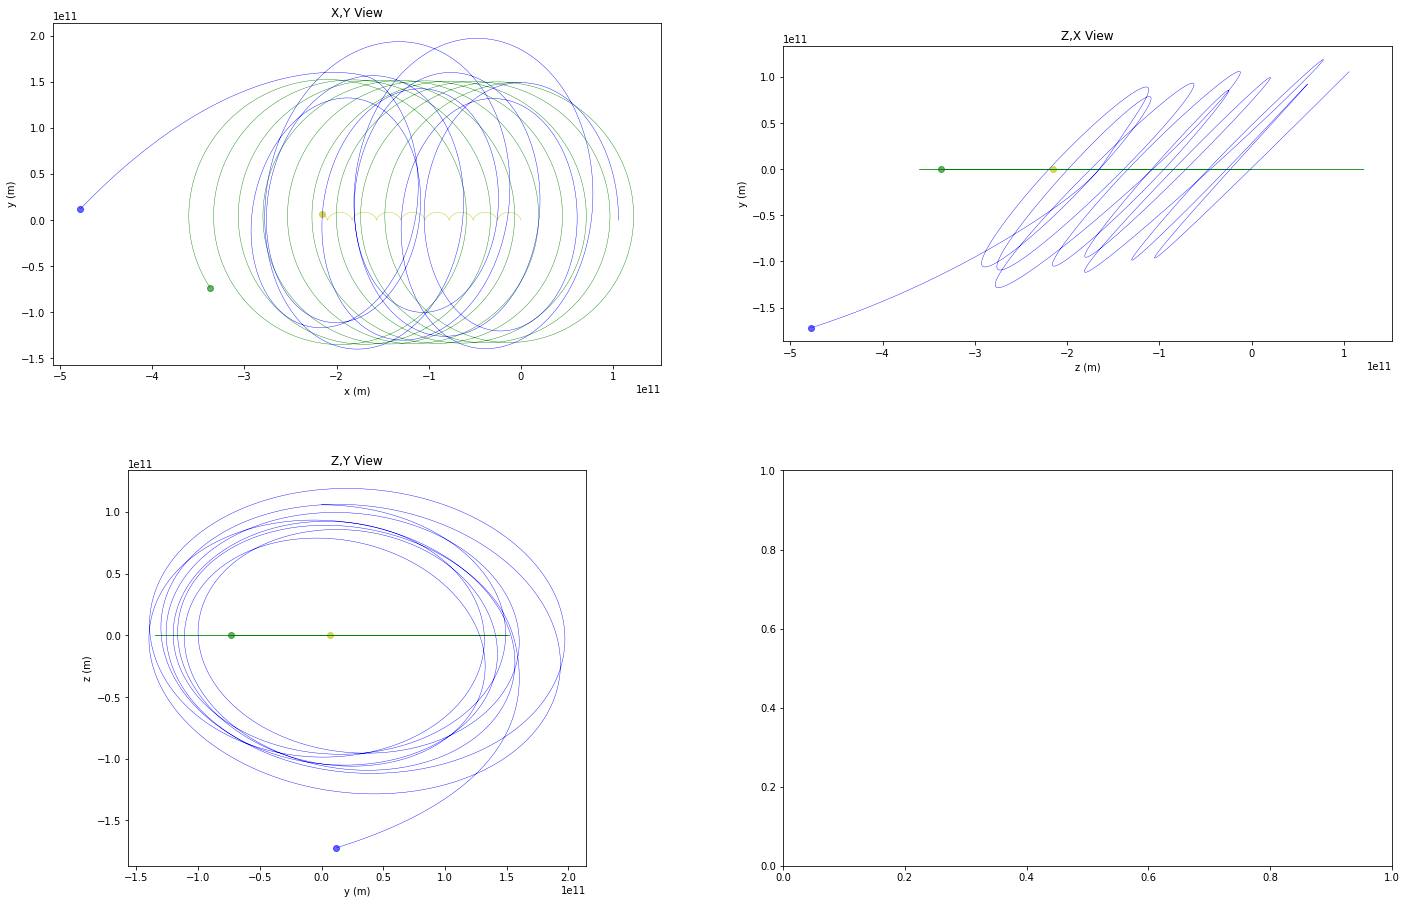

In [12]:
%matplotlib inline

# Default solar system objects
sun_3D = AstronomicalObject("Sun",
                         mass=1.989e+30,
                         position=np.array([0., 0, 0]),
                         velocity=np.array([0., 0, 0]),
                         radius=696_340_000,
                        #  radius=None,
                         colour = 'y',
                         colour2 = 'orange'
                        )
earth_3D_tilted = AstronomicalObject("Earth Tilted",
                           mass=5.972e+24,
                           position=np.array([np.cos(45*constants.degree)*constants.au, 0.,  np.sin(45*constants.degree)*constants.au]),
                           velocity=np.array([0., 107_226*constants.kmh, 0]), 
                           radius=None,
                           colour = 'blue',
                           colour2 = 'blue'
                          )
earth_3D = AstronomicalObject("Earth",
                           mass=5.972e+24*1e4,
                           position=np.array([0., constants.au, 0.]),
                           velocity=np.array([-107_226*constants.kmh, 0., 0]), 
                           radius=None,
                           colour = 'green',
                           colour2 = 'green'
                          )
moon = AstronomicalObject("Moon",
                            mass=7.34767309e+22,    
                            position=np.array([constants.au + 384_400_000, 0., 0]),
                            velocity=np.array([0., 107_226*constants.kmh + 1_022*constants.kmh, 0]),
                            radius=None,
                            colour = 'grey',
                            colour2 = 'grey'
                            )

sim = SimulationSystem()
sim.add_object(sun_3D)
sim.add_object(earth_3D)
sim.add_object(earth_3D_tilted)

timespan = 8*constants.year
step_size = 1800

positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=3, print_progress=True)
plot_sim_positions_3D(positions, ignore_radius=True)

In [73]:
np.cos(45*constants.degree)*constants.au

105781668823.03833

In [5]:
%matplotlib inline

# Default solar system objects
sun_3D = AstronomicalObject("Sun",
                         mass=1.989e+30,
                         position=np.array([0., 0, 0]),
                         velocity=np.array([0., 0, 0]),
                         radius=696_340_000,
                        #  radius=None,
                         colour = 'y',
                         colour2 = 'orange'
                        )
earth_3D_tilted = AstronomicalObject("Earth Tilted",
                           mass=5.972e+24,
                           position=np.array([np.cos(45*constants.degree)*constants.au, 0.,  np.sin(45*constants.degree)*constants.au]),
                           velocity=np.array([0., 107_226*constants.kmh, 0]), 
                           radius=None,
                           colour = 'blue',
                           colour2 = 'blue'
                          )
earth_3D = AstronomicalObject("Earth",
                           mass=5.972e+24*1e4,
                           position=np.array([0., constants.au, 0.]),
                           velocity=np.array([-107_226*constants.kmh, 0., 0]), 
                           radius=None,
                           colour = 'green',
                           colour2 = 'green'
                          )
moon = AstronomicalObject("Moon",
                            mass=7.34767309e+22,    
                            position=np.array([constants.au + 384_400_000, 0., 0]),
                            velocity=np.array([0., 107_226*constants.kmh + 1_022*constants.kmh, 0]),
                            radius=None,
                            colour = 'grey',
                            colour2 = 'grey'
                            )

sim = SimulationSystem()
sim.add_object(sun_3D)
sim.add_object(earth_3D)
sim.add_object(earth_3D_tilted)

timespan = 20*constants.year
step_size = 1800

positions, velocities, time_steps = sim.simulate(dt=step_size, num_steps = int(timespan / step_size), dimensions=3, print_progress=True)


earth_positions = positions[earth_3D]
earth_positions = list(zip(*earth_positions))

eart_tilted_positions = positions[earth_3D_tilted]
eart_tilted_positions = list(zip(*eart_tilted_positions))

sun_positions = positions[sun_3D]
sun_positions = list(zip(*sun_positions))

# find the max value out of all the values
max_val = max([max(earth_positions[0]), max(earth_positions[1]), max(earth_positions[2])])
max_val = max([max_val, max([max(eart_tilted_positions[0]), max(eart_tilted_positions[1]), max(eart_tilted_positions[2])])])
max_val = max([max_val, max([max(sun_positions[0]), max(sun_positions[1]), max(sun_positions[2])])])
# find the min value out of all the values
min_val = min([min(earth_positions[0]), min(earth_positions[1]), min(earth_positions[2])])
min_val = min([min_val, min([min(eart_tilted_positions[0]), min(eart_tilted_positions[1]), min(eart_tilted_positions[2])])])
min_val = min([min_val, min([min(sun_positions[0]), min(sun_positions[1]), min(sun_positions[2])])])

# get the difference between max and min
diff = max_val - min_val

Progress: 100%                                     
Complete.


In [6]:
from mayavi import mlab
import numpy as np




mlab.figure(bgcolor=(0.5, 0.5, 0.5))
mlab.plot3d(*earth_positions, time_steps, colormap='Blues', tube_radius=diff/1000)
mlab.plot3d(*eart_tilted_positions, time_steps, colormap='Greens', tube_radius=diff/1000)
mlab.plot3d(*sun_positions, time_steps, colormap='Reds', tube_radius=diff/1000)
# mlab.plot3d(*earth_positions, color=(0,0,1), tube_radius=diff/1000)
# mlab.plot3d(*eart_tilted_positions, color=(0,1,0), tube_radius=diff/1000)
# mlab.plot3d(*sun_positions, color=(1,0,0), tube_radius=diff/1000)
mlab.show()




def plot_with_mayavi(x, y, z, t):
    # mlab.figure(bgcolor=(1, 1, 1), size=(400, 400))
    mlab.figure(bgcolor=(0.5, 0.5, 0.5))
    # mlab.points3d(x, y, z, t, mode='sphere', color=(0, 0, 0), colormap='Reds', scale_factor=0.05)
    # mlab.points3d(x, y, z, mode='sphere', color=(0, 0, 0), colormap='Reds', scale_factor=0.05)
    # mlab.points3d(x, y, z, t)
    mlab.points3d(x, y, z)
    # mlab.points3d(y, x, z, t, color=(0, 0, 0))
    # mlab.points3d(x, y, z)
    mlab.show()

# plot_with_mayavi(*earth_positions, [])

x, y, z, t = (np.random.random((4, 1000))*1000)
# t = np.ones(1000)*500
# print(t)
# print(t)
# print(x)
# print(t)
plot_with_mayavi(x, y, z, t)

ImportError: Could not import backend for traitsui.  Make sure you
        have a suitable UI toolkit like PyQt/PySide or wxPython
        installed.

In [7]:
from mayavi import mlab

def test_plot3d():
    """Generates a pretty set of lines."""
    n_mer, n_long = 6, 11
    dphi = np.pi / 1000.0
    phi = np.arange(0.0, 2 * np.pi + 0.5 * dphi, dphi)
    mu = phi * n_mer
    x = np.cos(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
    y = np.sin(mu) * (1 + np.cos(n_long * mu / n_mer) * 0.5)
    z = np.sin(n_long * mu / n_mer) * 0.5

    l = plot3d(x, y, z, np.sin(mu), tube_radius=0.025, colormap='Spectral')
    return l

l = test_plot3d()

NameError: name 'plot3d' is not defined

In [9]:
from mayavi import mlab
import numpy as np

mlab.figure(bgcolor=(0, 0, 0))
ran = 100
mlab.plot3d(*[[i*i for i in range(-ran, ran)], [i for i in range(-ran, ran)], [i for i in range(-ran, ran)]], color=(1,1,1), tube_radius=ran**2*0.001)
# mlab.plot3d(*eart_tilted_positions, color=(0,1,0))
# mlab.plot3d(*sun_positions, color=(1,0,0))
mlab.show()


In [1]:
import numpy as np
from mayavi import mlab

x, y, z = np.random.random((3, 100))

fig = mlab.figure()
ax = mlab.axes(ranges=(0, 1, 0, 1, 0, 1), nb_labels=5)
ax.outline_axes.visible = False
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

mlab.points3d(x, y, z, scale_mode="none", scale_factor=0.1)
mlab.show()

AttributeError: 'Scene' object has no attribute 'axes'